In [34]:
import mbuild as mb

import foyer
from foyer import Forcefield as FF
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from foyer.xml_writer import write_foyer
from mbuild.formats.lammpsdata import write_lammpsdata

In [6]:
zdol = mb.load('test_molecules/Zdol.mol2')
krytox = mb.load('test_molecules/Krytox.mol2')
diglyme = mb.load('test_molecules/PFDiglyme.mol2')

pfe = FF(forcefield_files='PFE_charmmstyle.xml')
#pfe = FF(forcefield_files='PFEs.xml')

/home/puente/anaconda3/envs/mosdef36/lib/python3.6/site-packages/mbuild/utils/io.py:120: DeprecationWarning: openbabel 2.0 detected and will be dropped in a future release. Consider upgrading to 3.x.
  warnings.warn(msg, DeprecationWarning)
/home/puente/anaconda3/envs/mosdef36/lib/python3.6/site-packages/mbuild/utils/io.py:120: DeprecationWarning: openbabel 2.0 detected and will be dropped in a future release. Consider upgrading to 3.x.
  warnings.warn(msg, DeprecationWarning)
/home/puente/anaconda3/envs/mosdef36/lib/python3.6/site-packages/mbuild/utils/io.py:120: DeprecationWarning: openbabel 2.0 detected and will be dropped in a future release. Consider upgrading to 3.x.
  warnings.warn(msg, DeprecationWarning)


In [7]:
diglyme = mb.load('test_molecules/PFDiglyme.mol2')
diglyme.visualize()

/home/puente/anaconda3/envs/mosdef36/lib/python3.6/site-packages/mbuild/utils/io.py:120: DeprecationWarning: openbabel 2.0 detected and will be dropped in a future release. Consider upgrading to 3.x.
  warnings.warn(msg, DeprecationWarning)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# System Generation

Now we build a system of 256 perfluorodigylme molecules with mBuild in a box size consistent with the experimental density of 1.608785 g/mL at 298.146 K and 1 atm, atomtype with Foyer, then write to a LAMMPS datafile to perform a liquid-phase simulation.

In [8]:
system = mb.fill_box(compound=[diglyme], 
                     n_compounds=[256], 
                     box=[4.615, 4.615, 4.615])

/home/puente/anaconda3/envs/mosdef36/lib/python3.6/site-packages/mbuild/utils/io.py:120: DeprecationWarning: openbabel 2.0 detected and will be dropped in a future release. Consider upgrading to 3.x.
  warnings.warn(msg, DeprecationWarning)


In [9]:
system.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
system_typed = pfe.apply(system, assert_dihedral_params=False)

mb.formats.lammpsdata.write_lammpsdata(system_typed, filename='diglyme_box.data')

/home/puente/anaconda3/envs/mosdef36/lib/python3.6/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all proper dihedrals. Total system dihedrals: 9216, Parameterized dihedrals: 21504. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers.
  warnings.warn(msg)
/home/puente/anaconda3/envs/mosdef36/lib/python3.6/site-packages/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 6144, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


No urey bradley terms detected, will use angle_style harmonic
Charmm dihedrals detected, will use dihedral_style charmm


# Liquid NpT Simulation
Perform a brief simulation of 1 ns on 256 perfluorodiglyme molecules in the NPT ensemble, 1 atm, 298.15 K. 

Note that the simulation involves using the OPLS parameters in a CHARMM-style manner. This is because LAMMPS does not allow for phase-shifting in the dihedral potential function, which these parameters contain.

This simulation involves building the neighbor list on the GPU, so modification will be necessary to run if there are no GPUs available.

In [ ]:
#!mpirun -np 7 lmp_mpi -sf gpu -pk gpu 1 -in liquid_npt.txt
#!mpirun -np 7 lammps -in liquid_npt.txt

#!mpirun -np 7 lmp_mpi -sf gpu -pk gpu 1 -in liquid_npt.txt
#!mpirun -np 7 lammps -in liquid_npt.txt

# Gas Simulation

Performs five 10 ns simulation of 1 perfluorodiglyme molecule. Each one has a different seed for the intial temperature generation to obtain different sampling.

This requires a special build for "neigh_modify exclude molecule/inter all" to work properly. This exclude does not work with GPU acceleration.

In [104]:
#!lmp_mpi -in gas1.txt
#!lmp_mpi -in gas2.txt
#!lmp_mpi -in gas3.txt
#!lmp_mpi -in gas4.txt
#!lmp_mpi -in gas5.txt


#!lammps -in gas1.txt
#!lammps -in gas2.txt
#!lammps -in gas3.txt
#!lammps -in gas4.txt
#!lammps -in gas5.txt

# Analysis

This involves simple analysis of the data outputted by LAMMPS for the NpT simulation. Here we are computing the 

In [95]:
#data.to_csv('liquid_data.log', sep='\t')

In [10]:
N = 256
mol = 6.022*10**23/N
k_J = 1.38064852 * 10**-23
k_kcal = 1.38064852 * 10**-23 / 4184

In [28]:
def simavg(df, box_size=200):
    a = df.values
    a = a[1:]
    size = int(a.size / box_size)
    a = a.reshape(box_size, size)
    a = np.mean(a[1:], axis=1)
    
    return(np.mean(a))

def simstd(df, box_size=200):
    a = df.values
    a = a[1:]
    size = int(a.size / box_size)
    a = a.reshape(box_size, size)
    a = np.mean(a[1:], axis=1)
    
    return(np.std(a))

def gassimavg(df, box_size=200):
    a = df.values
    a = a[1:]
    size = int(a.size / box_size)
    a = a.reshape(box_size, size)
    a = np.mean(a[1:], axis=1)
    
    return(np.mean(a))

In [37]:
npt = pd.read_csv('liquid_npt.log', delim_whitespace=True, skiprows=14, nrows=2001)

# Pre-Processing 

eng  = ['PotEng', 'E_mol', 'KinEng', 'E_vdwl', 'E_coul', 'E_bond', 'E_long', 'E_tail', 'E_angle', 'E_dihed', 'Enthalpy', 'E_long']
for i in eng:
        npt[i] = npt[i] / 256


npt["Time"] = npt['Step']/1000000 #go from fs to ns

####################

time = npt['Time']

T = npt['Temp']
P = npt['Press']

V = npt['Volume'] / 10**27  #Vol in Liters

E_total  = npt['PotEng'] + npt['KinEng'] #U in kcal/mol
H = npt['Enthalpy'] #kcal/mol
PE = npt['PotEng']
KE = npt['KinEng']

box_length = npt['Lx']


Text(0.5, 1.0, 'Liquid-Phase Simulation, NpT Ensemble')

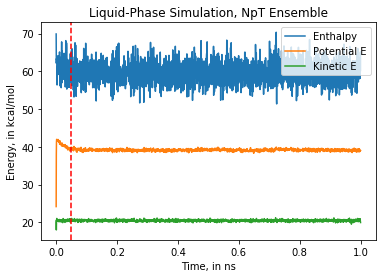

In [38]:
plt.plot(time, H, label='Enthalpy')
plt.plot(time, PE, label='Potential E')
plt.plot(time, KE, label='Kinetic E')

plt.xlabel('Time, in ns')
plt.ylabel('Energy, in kcal/mol')

plt.axvline(x=0.05, linestyle='--', c='red') #denotes start of block averaging

#plt.ylim(0, 100)

plt.legend(loc='best')
plt.title('Liquid-Phase Simulation, NpT Ensemble')

<>:6: DeprecationWarning: invalid escape sequence \A
<>:6: DeprecationWarning: invalid escape sequence \A
<>:6: DeprecationWarning: invalid escape sequence \A
<ipython-input-41-e06e9f2fdbf7>:6: DeprecationWarning: invalid escape sequence \A
  plt.ylabel('Side Length, in $\AA$')


Text(0.5, 1.0, 'Liquid-Phase Simulation')

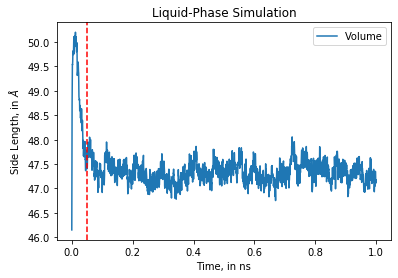

In [41]:
plt.plot(time, box_length, label='Volume')
# plt.plot(time, PE, label='Potential E')
# plt.plot(time, KE, label='Kinetic E')

plt.xlabel('Time, in ns')
plt.ylabel('Side Length, in $\AA$')

plt.axvline(x=0.05, linestyle='--', c='red') #denotes start of block averaging

#plt.ylim(0, 100)

plt.legend(loc='best')
plt.title('Liquid-Phase Simulation')

In [40]:
rho = 256 / simavg(V) / 1000 / (6.022*10**23) * 386.04

rho_std = rho / simavg(V)*simstd(V)

print(rho, rho_std)

1.5404043011560817 0.039662737625856044
